# Extract customisable time-series of inundation within a polygon using Landsat data

**What does this notebook do?** 

This notebook uses a polygon to query all of Landsat 5, 7 and 8 data available from 1987 onward, optionally filter to drop cloudy scenes, mask out remaining cloud and invalid data, then compute one of several water indices on the data to indentify open water. The resulting dataset can then be used to generate a timeseries of total inundated pixels which is exported as both a CSV of metrics and water index/RGB images for each timestep. 

This methodology is a simplified version of the Digital Earth Australia _Water Area Mapping and Monitoring_ product (WAMM). WAMM maps the location of persistent waterbodies in the Australian landscape, then monitors changes to the surface area of water within each waterbody through time. For more information, see the [following Jupyter notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/ClaireK/WaterbodyAreaMappingandMonitoring/GenerateWaterBodyPolygons.ipynb).

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`    

This notebook uses three external functions called `load_clearlandsat` and `rgb`. These functions are available in the `10_Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** August 2019

**Author:** Robbi Bishop-Taylor

## Import modules and functions

In [13]:
# Import required modules
import os
import sys
import datacube
import rasterio
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from datacube.helpers import write_geotiff
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEADataHandling
import DEAPlotting

# Define custom functions
def water_indices(ds, water_index='NDWI', custom_varname=None): 
    
    """
    Takes an xarray dataset containing spectral bands, calculates one of a 
    series of water indices, and adds the resulting array as a new variable 
    in the original dataset.    

    Last modified: July 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------  
    ds : xarray Dataset
        A two-dimensional or multi-dimensional array with spectral bands named 
        'red', 'green', 'blue', 'nir', 'swir1' or 'swir2'. These bands are used
        as inputs to calculate the selected water index.
    water_index : str, optional
        A string giving the name of the water index to calculate. Valid options:
        'NDWI' (Normalised Difference Water Index, McFeeters 1996), 
        'MNDWI' (Modified Normalised Difference Water Index, Xu 1996), 
        'AWEI_ns (Automated Water Extraction Index - no shadows, Feyisa 2014)',
        'AWEI_sh' (Automated Water Extraction Index - shadows, Feyisa 2014), 
        'WI' (Water Index, Fisher 2016) & 'TCW' (Tasseled Cap Wetness, Crist 1985).
        Defaults to 'NDWI'.        
    custom_varname : str, optional
        By default, the function will return the original dataset with a new
        water index variable named after `water_index` (e.g. NDWI). To specify
        a custom name instead, you can supply e.g. `custom_varname='water_index'`. 

    Returns
    -------
    ds : xarray Dataset
        The original xarray Dataset inputted into the function, with a new band
        containing the water index DataArray.
    """    
    
    # Dictionary containing water index band recipes
    water_index_dict = {# Normalised Difference Water Index, McFeeters 1996
                        'NDWI': lambda ds: (ds.green - ds.nir) / (ds.green + ds.nir),
        
                        # Modified Normalised Difference Water Index, Xu 2006
                        'MNDWI': lambda ds: (ds.green - ds.swir1) / (ds.green + ds.swir1),
        
                        # Automated Water Extraction Index (no shadows), Feyisa 2014
                        'AWEI_ns': lambda ds: (4 * (ds.green - ds.swir1) -
                                               (2.5 * ds.nir * + 2.75 * ds.swir2)),
        
                        # Automated Water Extraction Index (shadows), Feyisa 2014
                        'AWEI_sh': lambda ds: (ds.blue + 2.5 * ds.green - 
                                               1.5 * (ds.nir + ds.swir1) - 2.5 * ds.swir2),
    
                        # Water Index, Fisher 2016
                        'WI': lambda ds: (1.7204 + 171 * ds.green + 3 * ds.red + 
                                          70 * ds.nir - 45 * ds.swir1 - 71 * ds.swir2),
        
                        # Tasseled Cap Wetness, Crist 1985
                        'TCW': lambda ds: (0.0315 * ds.blue + 0.2021 * ds.green + 
                                           0.3102 * ds.red + 0.1594 * ds.nir - 
                                           0.6806 * ds.swir1 - 0.6109 * ds.swir2)} 
    
    # Select a water index function based on 'water_index'    
    water_index_func = water_index_dict[water_index]
    print(water_index_func)
    
    # Apply water index function to data and add to input dataset. If a custom name
    # is supplied for the output water index variable, use it.
    if custom_varname:        
        
        # Apply function after normalising to a 0.0-1.0 range by dividing by 10,000
        ds[custom_varname] = water_index_func(ds / 10000.0)
        
    else:
        
        # Apply function after normalising to a 0.0-1.0 range by dividing by 10,000
        ds[water_index] = water_index_func(ds / 10000.0)
    
    # Return input dataset with added water index variable
    return ds



## Set up required parameters
All parameters that need to be modified are listed below. The default values will load 25m resolution Landsat data for an example polygon, keeping only images with more than 90% cloud free pixels. These images will then be classified into water vs non-water using the `MNDWI` index using a threshold of 0.

In [2]:
# Time range including a from and to date to load data. Can be in the format 
# ('1995', '2003'), ('1995-01', '2003-12') or ('1995-01-01', '2003-12-30')
time_range = ('1995', '2003')

# A path to the polygon used to extract data from the datacube
polygon_path = '../Supplementary_data/Files/WA_example_waterbody.shp'

# The projection system you wish to load the data in; default is 'EPSG:3577'
output_crs = 'EPSG:3577'

# The resolution you wish to load the data at; default for Landsat is '(-25, 25)'
output_res = (-25, 25)

# The minimum proportion of valid non-cloudy pixels used to decide what images 
# to load. A value of 0.9 will only load images with less than 10% cloud/cloud shadow.
min_clearprop = 0.90

# Water index used to identify inundated pixels. Valid options include 'NDWI' (Normalised 
# Difference Water Index, McFeeters 1996), 'MNDWI' (Modified Normalised Difference Water 
# Index, Xu 1996), 'AWEI_ns (Automated Water Extraction Index - no shadows, Feyisa 2014)',
# 'AWEI_sh' (Automated Water Extraction Index - shadows, Feyisa 2014), 'WI' (Water Index, 
# Fisher 2016) & 'TCW' (Tasseled Cap Wetness, Crist 1985).
water_index = 'MNDWI'

# Water index threshold used to identify inundated pixels based on the specified water index
water_index_thresh = 0.0

## Read in polygon
Read in an example polygon from file, re-project it to match the desired output CRS, and prepare it to extract data from the datacube.

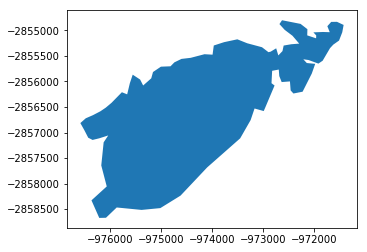

In [3]:
# Read in polygon from file into a geopandas dataframe
waterbody_polygon = gpd.read_file(polygon_path)

# Re-project polygon to match desired output CRS
waterbody_polygon_albers = waterbody_polygon.to_crs({'init': output_crs})
waterbody_polygon_albers.plot()

# Use the polygon to create a custom datacube geometry object based on 
# geojson and projection. This is used as in input to the datacube load.
geom = geometry.Geometry(waterbody_polygon_albers.iloc[0].geometry.__geo_interface__, 
                         crs=geometry.CRS(output_crs))


## Load data from Digital Earth Australia datacube
Here we use the `load_clearlandsat` function to extract a timeseries of Landsat data from the Landsat 5, 7 and 8 satellites. By default, we include the entire Landsat timeseries including images taken after the 2003 Landsat 7 SLC-off failure (to remove this, set `ls7_slc_off=True` to `ls7_slc_off=False`). The function keeps only images containing a minimum percentage of cloud-free pixels, and combines data from the three satellites into a single dataset with cloudy/invalid pixels marked as `NaN`.

In [4]:
# Connect to datacube database
dc = datacube.Datacube(app='Time series animation')

# Loading data from the datacube requires a spatiotemporal query that informs
# the datacube of the area, time period and other parameters used to load the data
query = {'geopolygon': geom,   
         'time': time_range,
         'output_crs': output_crs,
         'resolution': output_res} 

# The 'load_clearlandsat' function loads a subset of images from all of Landsat 5, 7
# and 8 based on their cloudiness, and returns a single combined dataset where all 
# remaining cloudy pixels are masked out as NAN values
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               query=query,
                                               sensors=['ls5', 'ls7', 'ls8'],
                                               masked_prop=min_clearprop, 
                                               mask_pixel_quality=True,
                                               mask_invalid_data=True,
                                               ls7_slc_off=True)

# So we can compute areas of NA pixels later in the analysis, we identify
# all non-NA pixels and add this as a new variable in the dataset
landsat_ds['is_valid'] = np.isfinite(landsat_ds.red)

# Print the dataset that is loaded from the datacube
print(landsat_ds)

Loading ls5
    Loading 93 filtered ls5 timesteps
Loading ls7
    Loading 49 filtered ls7 timesteps
Loading ls8
    Skipping ls8; no valid data for query
Combining and sorting ls5, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
<xarray.Dataset>
Dimensions:    (time: 142, x: 207, y: 155)
Coordinates:
  * y          (y) float64 -2.855e+06 -2.855e+06 ... -2.859e+06 -2.859e+06
  * x          (x) float64 -9.766e+05 -9.766e+05 ... -9.715e+05 -9.714e+05
  * time       (time) datetime64[ns] 1995-01-08T01:04:21.500000 ... 2003-12-25T01:24:01.500000
Data variables:
    blue       (time, y, x) float64 565.0 566.0 569.0 ... 462.0 509.0 479.0
    green      (time, y, x) float64 992.0 993.0 961.0 ... 844.0 873.0 845.0
    red        (time, y, x) float64 1.604e+03 1.637e+03 ... 1.231e+03 1.212e+03
    nir        (time, y, x) float64 1.955e+03 1.957e+03 ... 1.997e+03 1.974e+03
    swir1      (time, y, x) float64 2.849e+03 2.88e+03 ... 2.885e+03 2.811e+03
    swir

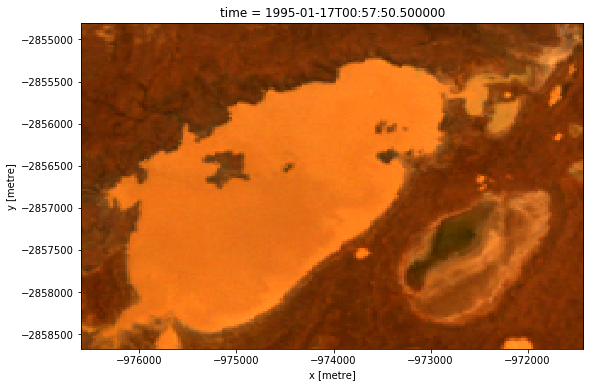

In [5]:
# Plot an example timestep in RGB
DEAPlotting.rgb(landsat_ds, index=1)

## Calculate water index 
We use the `water_indices` function to calculate a water index based on the loaded Landsat bands. By default, we use the Modified Normalised Difference Water Index ('MNDWI') to identify open water, however valid options are listed below (see `Set up required parameters`):
- NDWI (Normalised Difference Water Index, McFeeters 1996)
- MNDWI (Modified Normalised Difference Water, Index, Xu 1996)
- AWEI_ns (Automated Water Extraction Index - no shadows, Feyisa 2014)
- AWEI_sh (Automated Water Extraction Index - shadows, Feyisa 2014)
- WI (Water Index, Fisher 2016)
- TCW (Tasseled Cap Wetness, Crist 1985)

<function water_indices.<locals>.<lambda> at 0x7f5b983742f0>


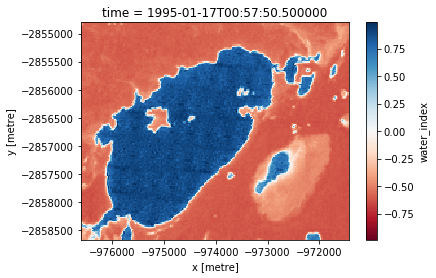

In [14]:
# We use the `water_indices` function to apply a water index of choice to the
# Landsat dataset. The new index will appear as a new generically named 
# 'water_index' variable in the dataset
landsat_ds = water_indices(landsat_ds, 
                           water_index=water_index, 
                           custom_varname='water_index')

# Plot result of the water index calculation
landsat_ds.water_index.isel(time=1).plot(cmap='RdBu')


## Mask out area outside polygon
To focus on the area of the actual waterbody to calculate inundation statistics, we mask out pixels located outside the polygon boundary.

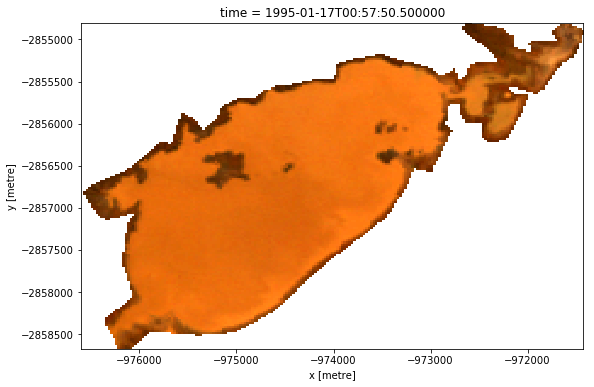

In [7]:
mask = rasterio.features.rasterize(shapes=[(waterbody_polygon_albers.iloc[0].geometry, 1)],
                                   out_shape=(landsat_ds.dims['y'], landsat_ds.dims['x']),
                                   transform=landsat_ds.geobox.transform)

# Apply raster mask to dataset. This will automatically apply the mask to 
# all timesteps and bands in the dataset.
landsat_masked = landsat_ds.where(mask)

# Plot a single timestep in RGB to verify that data outside the polygon has been masked out
DEAPlotting.rgb(landsat_masked, index=1)

## Export inundation metrics
Using the masked dataset created above, we can now calculate overall inundation statistics for every timestep in the dataset. We calculate four overall metric types: the total number of pixels/area within the polygon, the total number of inundated pixels/area, the total number of dry pixels/area, and the total number of nodata/NaN pixels/area. Finally, our output statistics are saved to file as a CSV.

In [8]:
# Calculate total, inundated, dry and NA stats across the timeseries
pxct = landsat_masked.is_valid.count(dim=['x', 'y'])
pxin = (landsat_masked.water_index >= water_index_thresh).sum(dim=['x', 'y'])
pxha = (landsat_masked.water_index < water_index_thresh).sum(dim=['x', 'y'])
pxna = (landsat_masked.is_valid == 0).sum(dim=['x', 'y'])

# Compute areas in hectares by multiplying by square metres
toha = pxct * np.abs(output_res[0] * output_res[1])
inha = pxin * np.abs(output_res[0] * output_res[1])
drha = pxha * np.abs(output_res[0] * output_res[1])
naha = pxna * np.abs(output_res[0] * output_res[1])

# Add to a single dataframe ready to be written out as a CSV with time as an index
wateranalysis_df = pd.DataFrame(data={'pxct': pxct, 'pxin': pxin, 'pxha': pxha, 'pxna': pxna, 
                                      'toha': toha, 'inha': inha, 'drha': drha, 'naha': naha },
                                index=landsat_masked.time.values)

# Write to file
wateranalysis_df.to_csv(f'rel_indundation_{time_range[0]}-{time_range[1]}.csv', index_label='time')

# Preview data
wateranalysis_df.head()


,pxct,pxin,pxha,pxna,toha,inha,drha,naha
1995-01-08 01:04:21.500,13578,3459,10119,0,8486250,2161875,6324375,0
1995-01-17 00:57:50.500,13578,10518,3060,0,8486250,6573750,1912500,0
1995-02-02 00:57:12.500,13578,10485,3093,0,8486250,6553125,1933125,0
1995-03-06 00:55:55.500,13578,11359,2219,0,8486250,7099375,1386875,0
1995-03-13 01:01:49.500,13578,11136,2441,1,8486250,6960000,1525625,625


## Plots
Plot some simple summary plots showing patterns of inundation across time for the polygon being analysed.

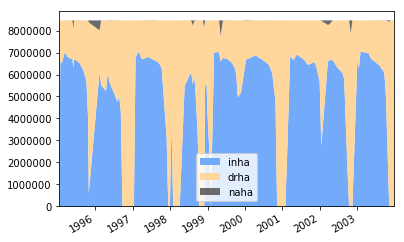

In [9]:
# Plot a stacked area plot containing all three categories
wateranalysis_df[['inha', 'drha', 'naha']].plot.area(color=['#73abfa', '#ffd79c', '#6b6b6b'], 
                                                     linewidth=0)

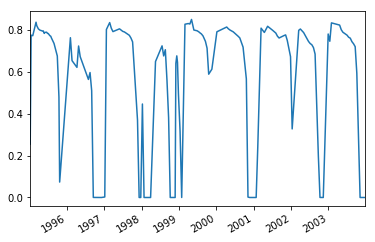

In [10]:
# Plot a normalised inundation percent based on proportion of valid area that was innundated
percent_inundation = wateranalysis_df.inha / (wateranalysis_df.toha - wateranalysis_df.naha)
percent_inundation.plot()

## Export RGB and water index images and geotiffs
Finally, we export some accompanying images to help interpret the metrics in the CSV. This includes an RGB image and a water index image for each timestep in the dataset. Optionally, we can also export a geotiff file for each timestep for both the RGB bands and the water index variable.

In [12]:
for time, i in landsat_ds.groupby('time'):
    
    ####################
    # Plot water index #
    ####################
    
    # Plot water index
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(i.water_index.values, 
              cmap='RdBu',
              extent=(i.x.min().item(), 
                      i.x.max().item(), 
                      i.y.min().item(), 
                      i.y.max().item()),
              vmin=-1.0, vmax=1.0)
    
    # Add polygon as an overlay over the top of the image
    waterbody_polygon_albers.plot(ax=ax, facecolor='None', 
                                  edgecolor='black', linestyle='--')
    
    # Export water index image to file
    water_index_png = f'd{str(time)[0:10]}_{water_index}.png'
    fig.savefig(water_index_png, bbox_inches='tight')
    
 
    ############
    # Plot RGB #
    ############
    
    # To plot the RGB array, first we need to load it
    # as a 3D numpy array with bands as the final axis
    rgb_array = np.transpose(i[['red', 'green', 'blue']]
                             .to_array()
                             .values, 
                             axes=[1, 2, 0])
    
    # Divide by 3000 to keep values between 0 and 1,
    # and create a reasonably good colour stretch
    rgb_array = (rgb_array / 3000).clip(0, 1)
    
    # Plot RGB array
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rgb_array, 
              extent=(i.x.min().item(), 
                      i.x.max().item(), 
                      i.y.min().item(), 
                      i.y.max().item()))
    
    # Add polygon as an overlay over the top of the image
    waterbody_polygon_albers.plot(ax=ax, facecolor='None', 
                                  edgecolor='black', linestyle='--')
    
    # Export RGB image to file
    rgb_png = f'd{str(time)[0:10]}_rgb.png'
    fig.savefig(rgb_png, bbox_inches='tight')
    
    
    ######################################
    # OPTIONAL - export geotiffs to file #
    ######################################
    
#     water_index_tif = f'd{str(time)[0:10]}_{water_index}.tif'
#     rgb_tif = f'd{str(time)[0:10]}_rgb.tif'
#     write_geotiff(filename=water_index_tif, dataset=i[['water_index']]) 
#     write_geotiff(filename=rgb_tif, dataset=i[['red', 'green', 'blue']]) 
    